In [1]:
%matplotlib inline
from IPython.display import IFrame

### to ignore some depreciation and future warnings in matplotlib and pystan

In [2]:
import warnings
warnings.simplefilter("ignore")

### usual imports

In [3]:
import os
import sys
from glob import glob 

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

### fbprophet 

In [5]:
IFrame(src='https://facebook.github.io/prophet/', width=1500, height=600)

In [6]:
from fbprophet import Prophet

### scikit learn Mean Absolute Error metrics function (MAE)

In [7]:
from sklearn.metrics import mean_absolute_error as MAE

### seaborn for visualisation 

In [8]:
import seaborn as sns

### read the data: cycling counts over Tamaki drive 

the data is taken from [https://awcc.mrcagney.works/](https://awcc.mrcagney.works/)

In [9]:
from IPython.display import IFrame

In [10]:
IFrame(src='https://awcc.mrcagney.works/', width=1500, height=600)

### for a better view of the location of the counters, we're gonna create an interactive map in the Jupyter Notebook using [https://github.com/python-visualization/folium](https://github.com/python-visualization/folium)

#### reads in the locations of the counters 

In [11]:
loc_counters = pd.read_csv('../data/cycling_Auckland/cycling_counters.csv')

In [12]:
loc_counters.head()

#### we're only keeping the counters for cyclists

In [13]:
loc_counters = loc_counters.query("user_type == 'Cyclists'")

In [14]:
loc_counters.query("name == 'Tamaki Drive EB'")

In [15]:
center_lat = loc_counters.query("name == 'Tamaki Drive EB'").latitude.values[0]
center_lon = loc_counters.query("name == 'Tamaki Drive EB'").longitude.values[0]

### display the counters locations on an interactive map

In [16]:
import folium
from folium.plugins import MarkerCluster

In [17]:
folium.__version__

'0.5.0+146.g41e494d'

this is the development version of folium

In [18]:
m = folium.Map(
    location=[-36.848, 174.789],
    zoom_start=13,
    tiles='OpenStreetMap', 
    width='80%'
)

m.add_child(folium.LatLngPopup())

# marker_cluster = MarkerCluster().add_to(m)

for i, row in loc_counters.iterrows():
    name = row['name']
    lat = row.latitude
    lon = row.longitude
    opened = row.setup_date
#     folium.Marker([lat, lon], popup='<i>{}</i>'.format(name), tooltip=name).add_to(marker_cluster)
    folium.Marker([lat, lon], popup='<b>{}</b></br><i>setup date = {}</i>'.format(name, opened), tooltip=name).add_to(m)

In [19]:
m

### now reads the cycling counts

In [20]:
lfiles = glob('../data/cycling_Auckland/cycling_counts_????.csv')

In [21]:
lfiles.sort()

In [22]:
lfiles

['../data/cycling_Auckland/cycling_counts_2010.csv',
 '../data/cycling_Auckland/cycling_counts_2011.csv',
 '../data/cycling_Auckland/cycling_counts_2012.csv',
 '../data/cycling_Auckland/cycling_counts_2013.csv',
 '../data/cycling_Auckland/cycling_counts_2014.csv',
 '../data/cycling_Auckland/cycling_counts_2015.csv',
 '../data/cycling_Auckland/cycling_counts_2016.csv',
 '../data/cycling_Auckland/cycling_counts_2017.csv',
 '../data/cycling_Auckland/cycling_counts_2018.csv']

In [23]:
l = []
for f in lfiles: 
    d = pd.read_csv(f, index_col=0, parse_dates=True, usecols=['datetime', 'Tamaki Drive EB','Tamaki Drive WB'])
    l.append(d)

In [24]:
df = pd.concat(l, axis=0)

In [25]:
df.head()

In [26]:
df.tail()

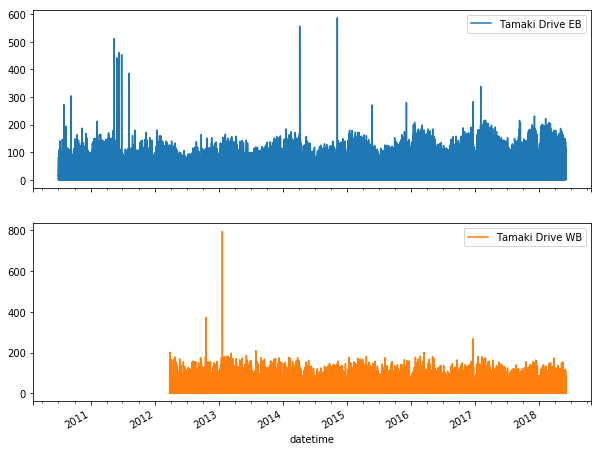

In [27]:
df.plot(subplots=True, figsize=(10, 8));

### seasonal cycle 

Text(0.5,0,'day of year')

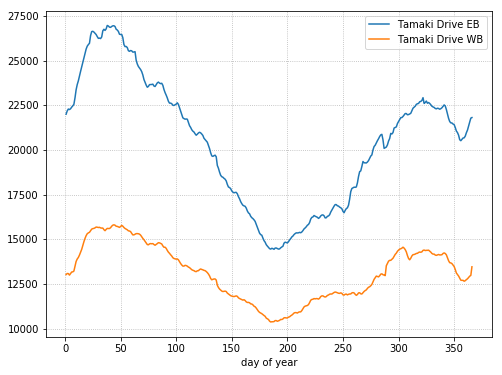

In [28]:
f, ax = plt.subplots(figsize=(8,6)) 
df.rolling(window=30*24, center=True).sum().groupby(df.index.dayofyear).mean().plot(ax=ax)
ax.grid(ls=':')
ax.set_xlabel('day of year')

### weekly cycle 

Text(0.5,0,'day of week')

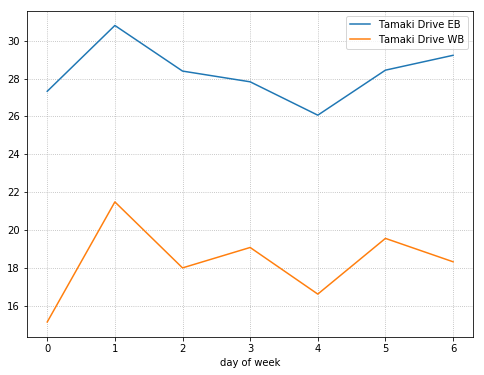

In [29]:
f, ax = plt.subplots(figsize=(8,6)) 
df.groupby(df.index.dayofweek).mean().plot(ax=ax)
ax.grid(ls=':')
ax.set_xlabel('day of week')

### daily cycle 

In [30]:
summary_hour = df.groupby(df.index.hour).describe()

In [31]:
summary_hour.head()

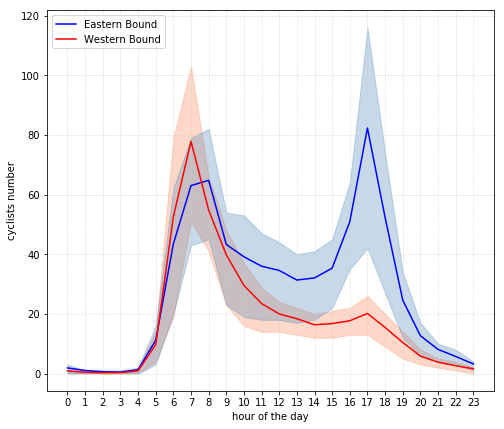

In [32]:

f, ax = plt.subplots(figsize=(8,7))

ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','mean')], color='b', label='Eastern Bound')
ax.plot(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','mean')], color='r', label='Western Bound')

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive WB','25%')], \
                summary_hour.loc[:,('Tamaki Drive WB','75%')], color='coral', alpha=0.3)

ax.fill_between(summary_hour.index, summary_hour.loc[:,('Tamaki Drive EB','25%')], \
                summary_hour.loc[:,('Tamaki Drive EB','75%')], color='steelblue', alpha=0.3)

ax.legend(loc=2)

ax.set_xticks(range(24));
ax.grid(ls=':', color='0.8')

ax.set_xlabel('hour of the day')

ax.set_ylabel('cyclists number');

### getting rid of the outliers using a median filter 

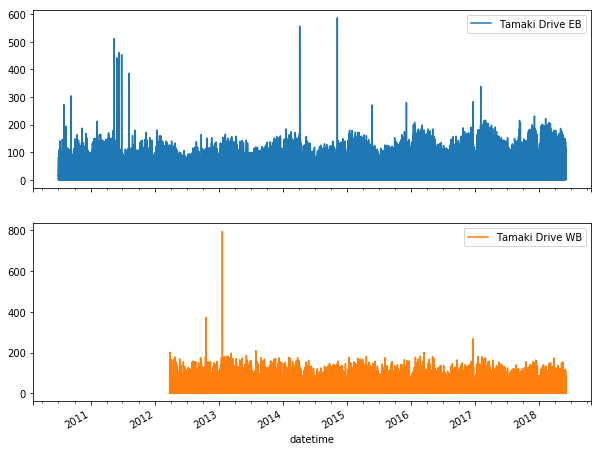

In [33]:
df.plot(subplots=True, figsize=(10, 8));

In [34]:
def median_filter(df, varname = 'Tamaki Drive EB', window=24, std=2): 
    
    dfc = df.copy() 
    
    dfc = dfc.loc[:,[varname]]
    
    dfc['median']= dfc[varname].rolling(window, center=True).median()
    
    dfc['std'] = dfc[varname].rolling(window, center=True).std()
    
    dfc.loc[dfc.loc[:,varname] >= dfc['median']+std*dfc['std'], varname] = np.nan
    
    dfc.loc[dfc.loc[:,varname] <= dfc['median']-std*dfc['std'], varname] = np.nan
    
    return dfc.loc[:, varname]

In [35]:
varname = 'Tamaki Drive EB'

In [36]:
window = 24

In [37]:
df.loc[:,varname] = median_filter(df, varname = varname, window=window, std=2)

In [38]:
varname = 'Tamaki Drive WB'

In [39]:
df.loc[:,varname] = median_filter(df, varname = varname, window=window, std=2)

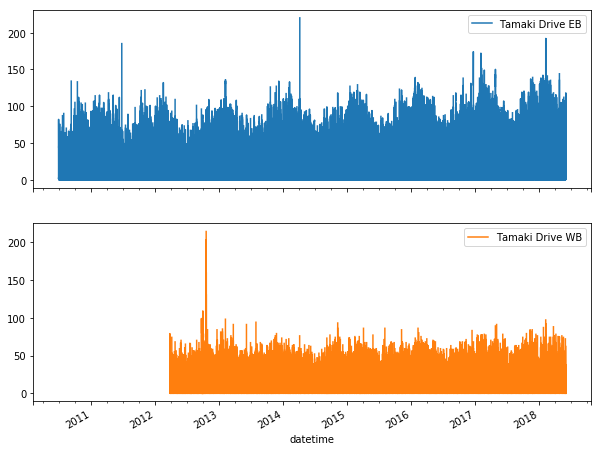

In [40]:
df.plot(subplots=True, figsize=(10, 8));

### resampling at the daily time-step


In [41]:
df = df.resample('1D').sum()

In [42]:
df.head()

In [43]:
df.tail()

### we're gonna look at the cyclists count for Eastern Bound Tamaki Drive ... starting in 2011 as it is when the climate data starts

In [44]:
data = df.loc['2011':,['Tamaki Drive EB']]

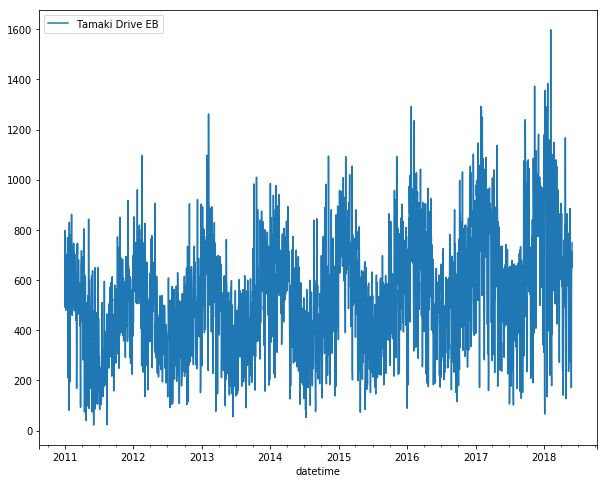

In [45]:
data.plot(figsize=(10,8))

### preparing the data 

In [46]:
data = data.rename({'Tamaki Drive EB':'y'}, axis=1)

In [47]:
data.tail()

In [48]:
def add_regressor(data, regressor, varname=None): 
    
    """
    adds a regressor to a dataframe of targets
    """
    
    data.loc[:,varname] = regressor.loc[:,varname]
    
    return data

In [49]:
def prepare_data(data, year=2017): 
    
    """
    prepare the data for ingestion by fbprophet: 
    
    1) divide in training and test set, using the `year` parameter (int)
    
    2) reset the index and rename the `datetime` column to `ds`
    
    returns the training and test dataframes
    """
    
    
    data_train = data.loc[:str(year - 1),:]
    
    data_test = data.loc[str(year):,:]
    
    data_train.reset_index(inplace=True)
    
    data_test.reset_index(inplace=True)
    
    data_train = data_train.rename({'datetime':'ds'}, axis=1)
    
    data_test = data_test.rename({'datetime':'ds'}, axis=1)
    
    return data_train, data_test

In [50]:
def make_verif(forecast, data_train, data_test): 
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [51]:
def plot_verif(verif, year=2017): 
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)

In [52]:
def plot_verif_component(verif, component='rain', year=2017): 
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
        
    ax.plot(train.index, train.loc[:,component], color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.loc[:, component+'_lower'], train.loc[:, component+'_upper'], color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
        
    ax.plot(test.index, test.loc[:,component], color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.loc[:, component+'_lower'], test.loc[:, component+'_upper'], color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)

In [53]:
def add_regressor_to_future(future, regressors_list): 
    
    futures = future.copy() 
    
    futures.index = pd.to_datetime(futures.ds)
    
    regressors = pd.concat(regressors_list, axis=1)
    
    futures = futures.merge(regressors, left_index=True, right_index=True)
    
    futures = futures.reset_index(drop = True) 
    
    return futures

In [54]:
data_train, data_test = prepare_data(data, 2017)

In [55]:
m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [56]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


### make the `future` dataframe 

In [57]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [58]:
future.head()

In [59]:
future.tail()

In [60]:
forecast = m.predict(future)

### plots the `components` of the forecast (trend + cyclic component [yearly seasonality, weekly seasonality] at this stage)

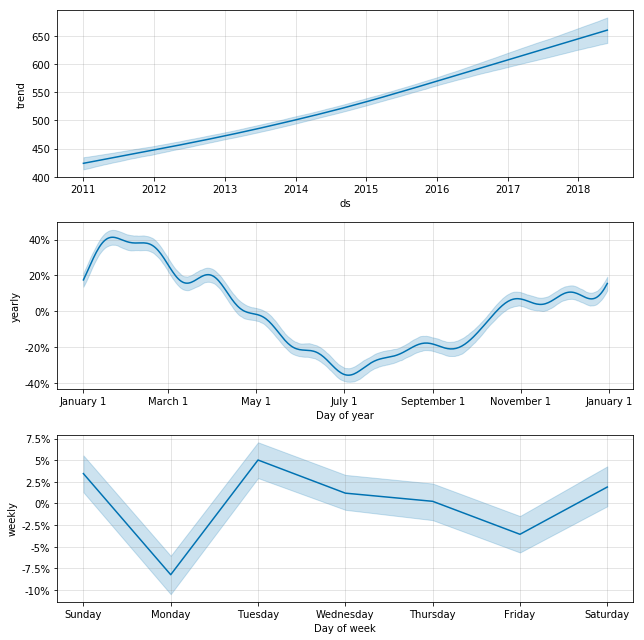

In [61]:
f = m.plot_components(forecast)

### put it all together with the actual observations 

In [62]:
verif = make_verif(forecast, data_train, data_test)

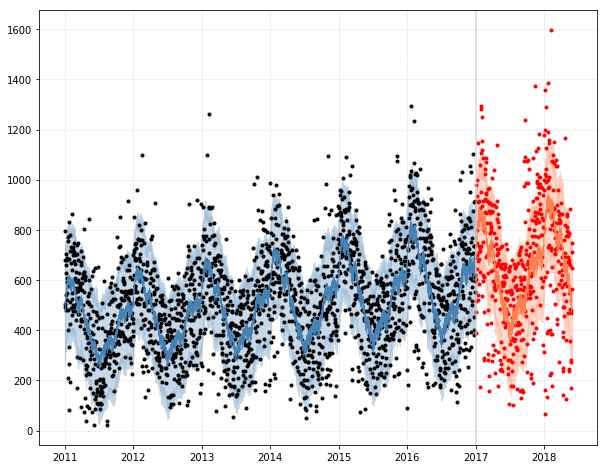

In [63]:
plot_verif(verif)

### scatter plot, marginal distribution and correlation between observations and modelled / predicted values 

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


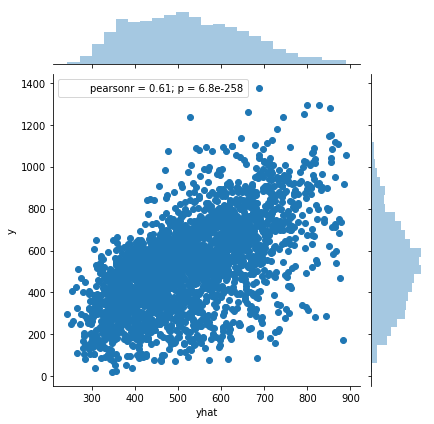

In [64]:
sns.jointplot(x='yhat', y='y', data = verif.loc[:'2017',:]);

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


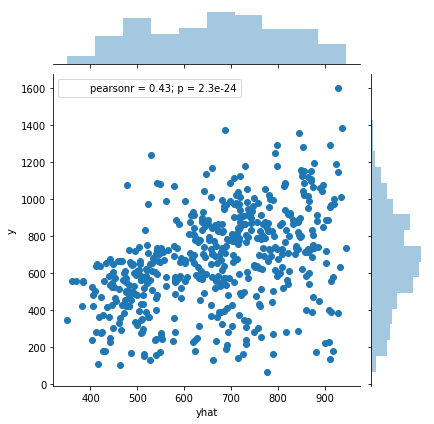

In [65]:
sns.jointplot(x='yhat', y='y', data = verif.loc['2017':,:])

### Mean Absolute Error (in number of cyclists)

In [66]:
MAE(verif.y.values, verif.yhat.values)

137.52597721312475

## now incorporating the effects of the holidays 

In [67]:
holidays_calendar = pd.read_csv('../data/holidays_calendars_2011_2018.csv')

In [68]:
holidays_calendar.loc[:,'ISO_date'] = pd.to_datetime(holidays_calendar.loc[:,'ISO_date'], dayfirst=True)

In [69]:
holidays_calendar = holidays_calendar.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [70]:
holidays_calendar = holidays_calendar.loc[-holidays_calendar.notes.str.contains('Not a public'),:]

In [71]:
holidays = holidays_calendar.loc[(holidays_calendar.loc[:,'Regional'] == 0) | holidays_calendar.RGR.str.contains('Auckland'),:]

In [72]:
holtype = 'category'

In [73]:
if holtype == 'category': 
    holidays = holidays.loc[:,['ISO_date','holiday_category']]
    holidays = holidays.rename({'holiday_category':'holiday'}, axis=1)
if holtype == 'code': 
    holidays = holidays.loc[:,['ISO_date','holiday_code']]
    holidays = holidays.rename({'holiday_code':'holiday'}, axis=1)
else: 
    holidays = holidays.loc[:,['ISO_date','holiday']]

In [74]:
holidays = holidays.rename({'ISO_date':'ds'}, axis=1)

In [75]:
holidays.tail()

In [76]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [77]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [78]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [79]:
forecast = m.predict(future)

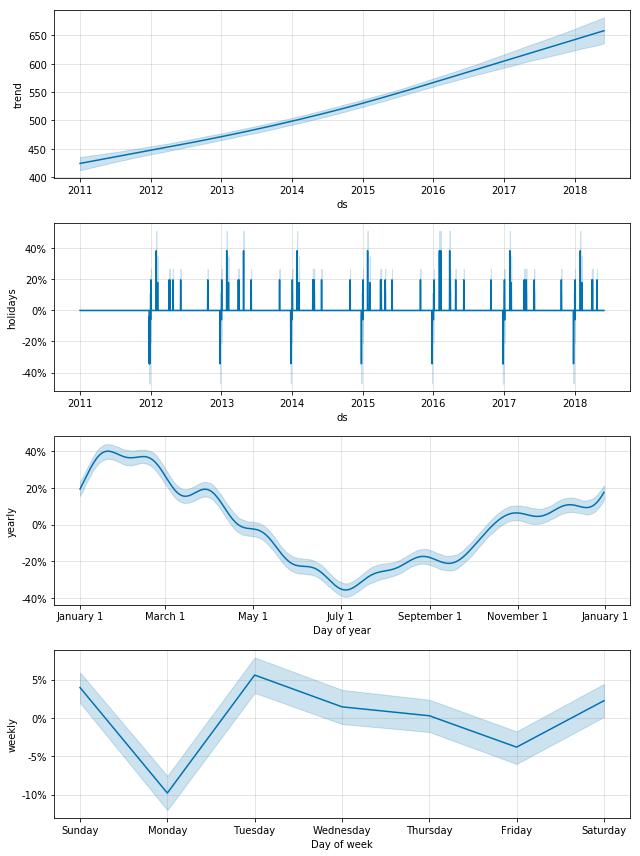

In [80]:
f = m.plot_components(forecast)

In [81]:
verif = make_verif(forecast, data_train, data_test)

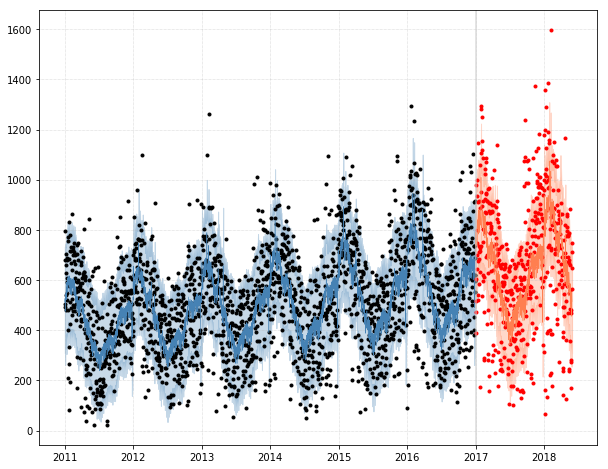

In [82]:
plot_verif(verif)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


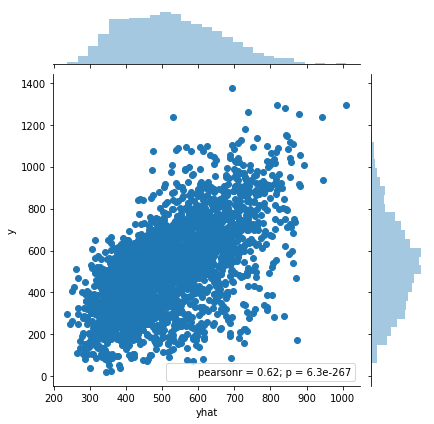

In [83]:
sns.jointplot(x='yhat', y='y', data = verif.loc[:'2017',:])

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


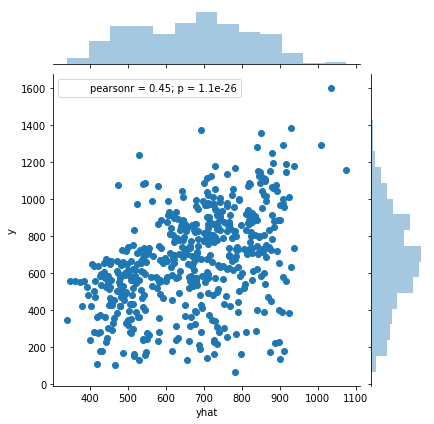

In [84]:
sns.jointplot(x='yhat', y='y', data = verif.loc['2017':,:])

In [85]:
MAE(verif.y.values, verif.yhat.values)

136.62256027581617

## incorporating the effects of weather conditions

In [86]:
temp = pd.read_csv('../data/weather/Mangere_EWS_temp.csv', index_col=0, parse_dates=True)

In [87]:
rain = pd.read_csv('../data/weather/Mangere_EWS_rain.csv', index_col=0, parse_dates=True)

In [88]:
sun = pd.read_csv('../data/weather/Mangere_EWS_sun.csv', index_col=0, parse_dates=True)

### interpolate so that there are no missing values 

In [89]:
temp = temp.interpolate(method='linear')

In [90]:
rain = rain.interpolate(method='linear')

In [91]:
sun = sun.interpolate(method='linear')

### adds the climate regressors to the data 

In [92]:
data_with_regressors = add_regressor(data, temp, varname='temp')

In [93]:
data_with_regressors = add_regressor(data_with_regressors, rain, varname='rain')

In [94]:
data_with_regressors = add_regressor(data_with_regressors, sun, varname='sun')

In [95]:
data_with_regressors.head()

In [96]:
data_with_regressors.tail()

### prepare the data and subsets (train and test set)

In [97]:
data_train, data_test = prepare_data(data_with_regressors, 2017)

In [98]:
m = Prophet(mcmc_samples=300, holidays=holidays, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [99]:
m.add_regressor('temp', prior_scale=0.5, mode='multiplicative')
m.add_regressor('rain', prior_scale=0.5, mode='multiplicative')
m.add_regressor('sun', prior_scale=0.5, mode='multiplicative')

In [100]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [101]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [102]:
futures = add_regressor_to_future(future, [temp, rain, sun])

In [103]:
forecast = m.predict(futures)

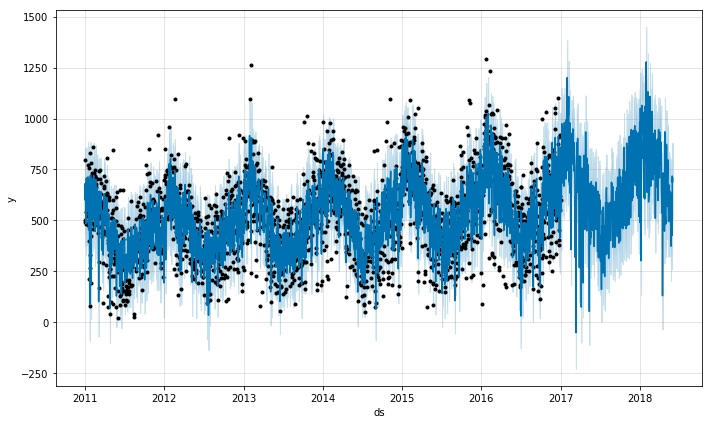

In [104]:
f = m.plot(forecast)

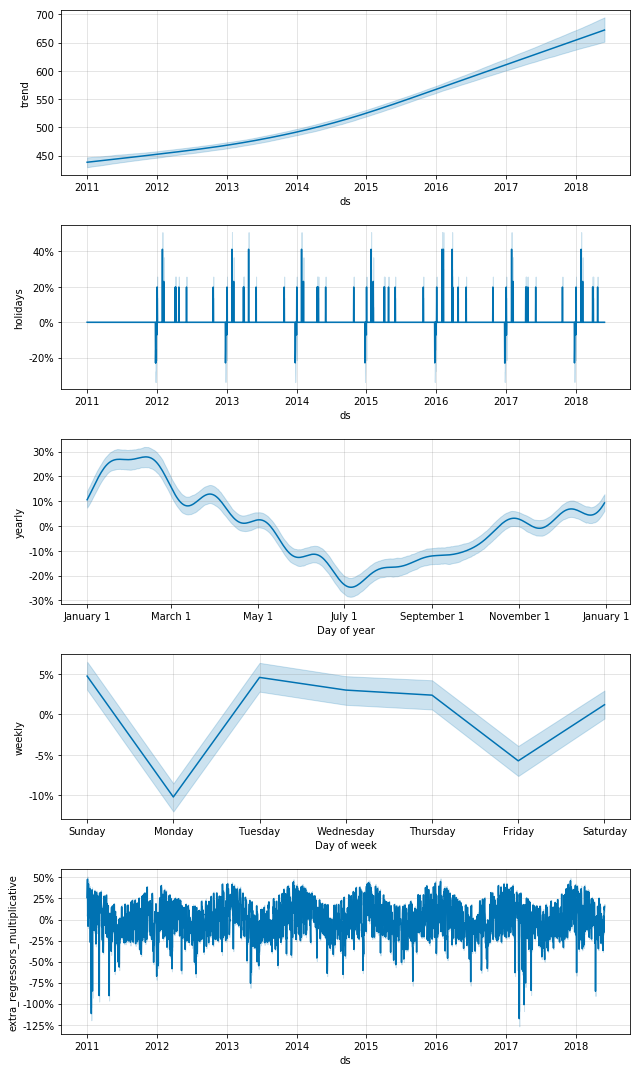

In [105]:
f = m.plot_components(forecast)

In [106]:
verif = make_verif(forecast, data_train, data_test)

In [107]:
verif.head()

In [108]:
verif.loc[:,'yhat'] = verif.yhat.clip_lower(0)

In [109]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip_lower(0)

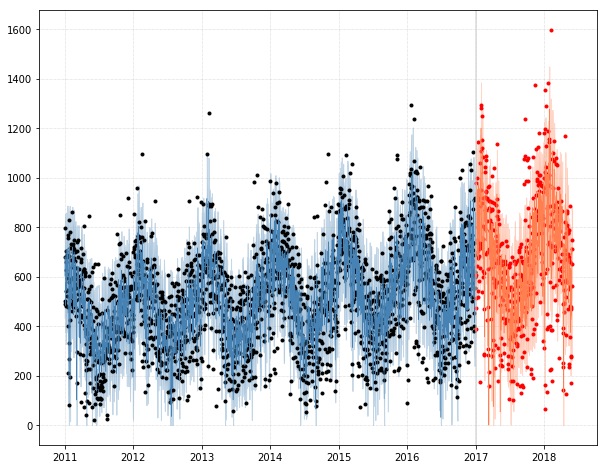

In [110]:
plot_verif(verif)

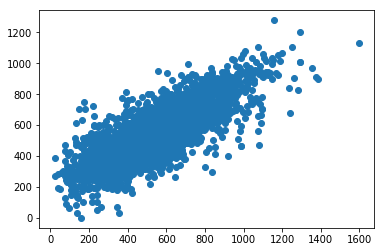

In [111]:
plt.scatter(verif.y, verif.yhat)

In [112]:
verif.loc[:'2017',['y','yhat']].corr()

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


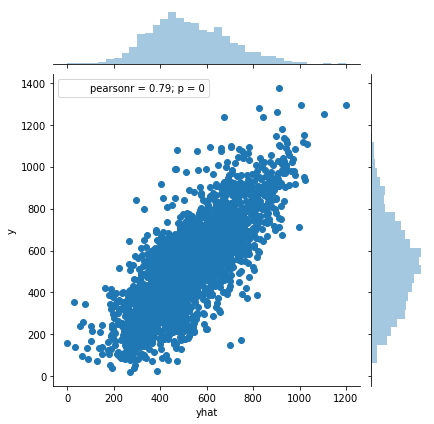

In [113]:
sns.jointplot(x='yhat', y='y', data = verif.loc[:'2017',:])

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


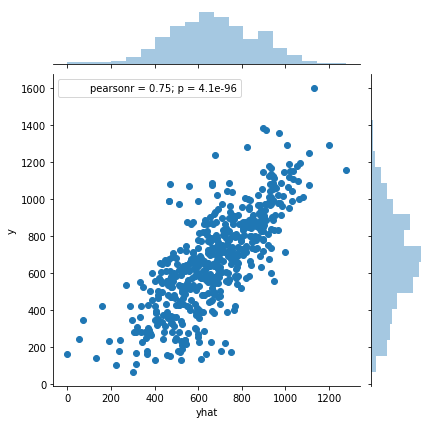

In [114]:
sns.jointplot(x='yhat', y='y', data = verif.loc['2017':])

### Mean Absolute Error 

In [115]:
MAE(verif.y.values, verif.yhat.values)

104.99251156103436

### plot the contribution of the different climate variables to the response variable (in percentage of the trend component, as we chose a multiplicative model)

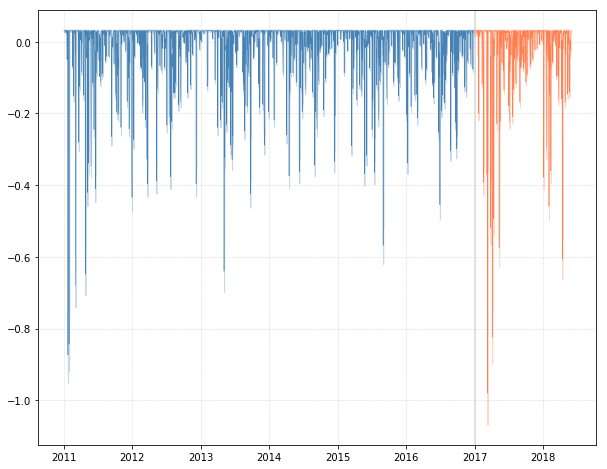

In [116]:
plot_verif_component(verif, component = 'rain')

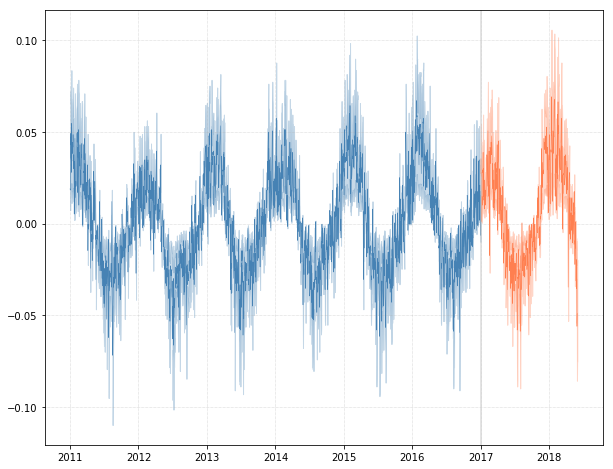

In [117]:
plot_verif_component(verif, component = 'temp')

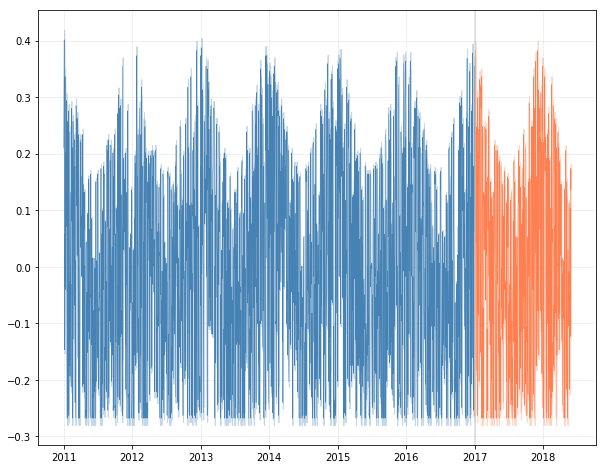

In [118]:
plot_verif_component(verif, component = 'sun')

### plots the combined contribution of the climate extra-regressors

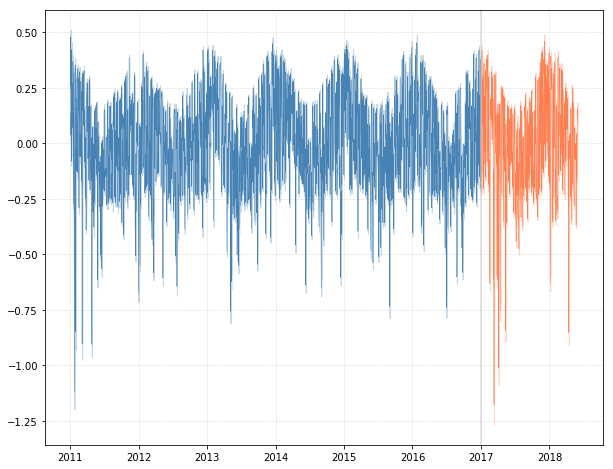

In [119]:
plot_verif_component(verif, component = 'extra_regressors_multiplicative')

### zoom in on the post 2016 period (test set)

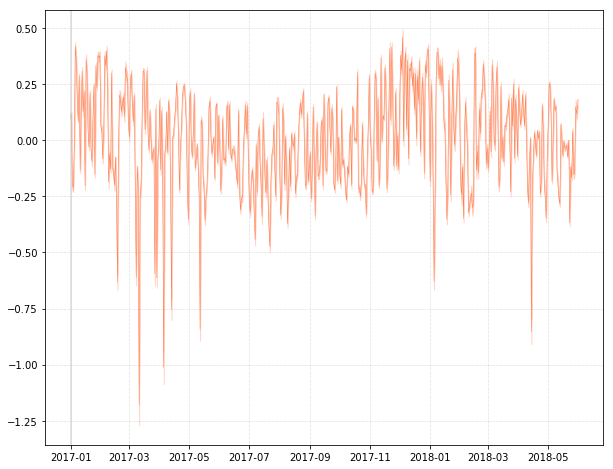

In [120]:
plot_verif_component(verif.loc['2016-12-31':,:], component = 'extra_regressors_multiplicative')

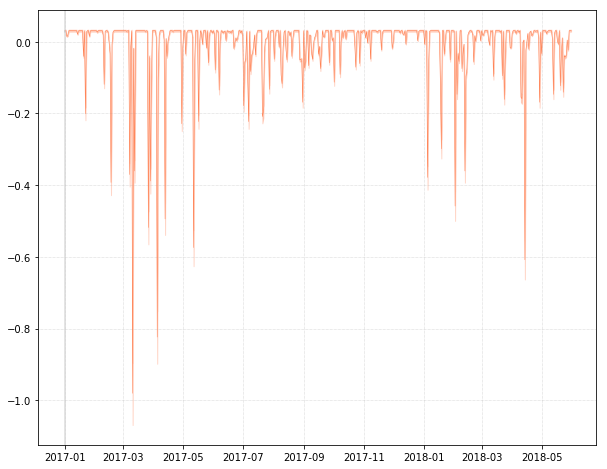

In [121]:
plot_verif_component(verif.loc['2016-12-31':,:], component = 'rain')